In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
from utils import *
import math


In [2]:
class Node(torch.nn.Module):
    def __init__(self, thresh = 1, decay_rate = 0.9, lr = 0.1, name = "Node"):
        super(Node, self).__init__()
        
        self.decay_rate = torch.tensor(decay_rate).float()
        self.lr = lr
        
        self.connections = []
        self.name = name
        
        self.thresh = thresh
        self.lr_decay = 0.95
        
    def add(self, x):
        self.connections.append(x)
        self.weights = torch.zeros(len(self.connections))
        self.charges = torch.zeros(len(self.connections))
        
        self.expected_error = torch.ones(len(self.connections)) #* 0.1
        self.mean =  torch.ones(len(self.connections))
        #self.reset_parameters()
        
    def get_ratios(self):
        ratios = torch.zeros([len(self.connections)])
        for i in range(len(ratios)):
            #ratios[i] = (self.expected_error/self.connections[i].expected_error)**1/2
            ratios[i] = (self.get_uncertainty()/self.connections[i].get_uncertainty())
            #ratios[i] = self.connections[i].expected_error/self.expected_error
        
        return ratios
    
    def correct_weights(self):
        r = self.get_ratios()
        out = torch.zeros([len(self.connections)])
        for i in range(len(self.connections)):
            #calculate correction
            #c = (-self.connections[i].get_weight(self) - (r[i] * self.weights[i]))/ (r[i] + 1)
            c = (-self.connections[i].get_maxl(self) - (r[i] * self.max_l()[i]))/ (r[i] + 1)
            
            
            #Calculate normilazing coefficient
            n = torch.max(self.connections[i].get_maxl(self), self.max_l()[i]).float()
            
            #add to other and self weight
            #self.connections[i].add_to_weight(self, c, norm = n)
            out[i] = (self.max_l()[i] + c)/n
            
        return out
    
    def get_weight(self, x):
        #for w,c in zip(self.max_l(),self.connections):
        for w,c in zip(self.weights,self.connections):    
            if c is x:
                return w
    
    def get_maxl(self, x):
        for w,c in zip(self.max_l(),self.connections):   
            if c is x:
                return w
    
    def add_to_weight(self, x, n, norm = 1):
        #print(self.weights)
        for i in range(len(self.connections)):
            if self.connections[i] is x:
                self.weights[i] += n
                self.weights[i] /= norm
    
    def decay(self):
        self.charges *= self.decay_rate
        #self.charges -= self.decay_rate
        
        #noise = -torch.abs(torch.distributions.Normal(0,self.decay_rate).sample([len(self.connections)]) )
       # self.charges[self.charges != 0] += noise
        self.charges[self.charges < 0] = 0
        
    def nonlin(self, x):
        return torch.tanh(x)
    
    def forward(self, x):
        noise = torch.distributions.Normal(0,0.2).sample([len(self.connections)])
        self.charges += x + (noise * x)
        self.decay()
        print(self.charges)
            
        return  0#self.get_charge()
    
    def get_charge(self):
        return torch.sum(self.charges)#torch.sum(self.nonlin(self.charges * self.weights))
    
    def in_spike(self):
        #noise = torch.distributions.Normal(0,0.05).sample([len(self.connections)])
        c = self.charges# + noise#torch.log10(self.get_charge()+ 0.00001)/torch.log10(self.decay_rate)
        
        likelihood =  torch.min(normal(c, self.mean, self.expected_error**(1/2)).float(),torch.tensor([0.8]).float()).float()
        #likelihood = torch.min(normal(c, self.mean, self.get_uncertainty(c)).float(),torch.tensor([0.8]).float()).float()
        
        lr = 0.1
        print("Likelihood of sample : {}".format(likelihood))
        self.expected_error += (((torch.abs(c - self.mean)**2)-self.expected_error))*(likelihood+lr)*self.expected_error
        
        self.mean += ((c - self.mean))  * self.expected_error# * (likelihood + lr) 
        
       
        #delta_w = (self.max_l() - self.weights) * 0.4
        new_w = self.correct_weights()#self.max_l())
        delta_w = (new_w - self.weights) * 0.5
        
        self.weights += delta_w
        
        
        
        self.charges = torch.zeros(self.charges.shape)
    
    def get_uncertainty(self, c = -1):
        if(c == -1):
            c = self.mean
        v = (torch.log10(c + 0.01)/torch.log10(self.decay_rate)) * (self.expected_error)
        return torch.max(v**1/2, self.expected_error**1/2)
    
    def max_l(self):
        #return normal(torch.max(self.mean,torch.tensor([0.1]).float()) , self.mean, self.expected_error)
        return normal(self.mean , self.mean, self.get_uncertainty())
    
    def out_spike(self):
        pass
        
    def reset_parameters(self):
        stdv = 1 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(0, stdv)
    
    def __str__(self):
        return ("Weights : {}, mean : {}, exp_error : {}, uncertainty : {}".format(self.weights, self.mean, 
                                                                                   self.expected_error, self.get_uncertainty()))
           
class SpikingNeuron(torch.nn.Module):
    def __init__(self, n_out, sigmoid = True, verbose = False, thresh = 1, lr = 0.1):
        super(SpikingNeuron, self).__init__()
        self.thresh = thresh
        self.n_out = n_out
        self.verbose = verbose
        self.lr = lr
        
        
        self.nodes = []
        for i in range(n_out):
            self.nodes.append(Node(thresh = thresh, name = "Node{}".format(i)))
            
        for i in self.nodes:
            for j in self.nodes:
                if not (i is j):
                    i.add(j)
        
        
    def forward(self, x):
        if(x.shape[0] != self.n_out):
            raise Exception(
                'number of inputs must equal number of connections, {} and {} where given'.format(x.shape[0],self.n_out))
        
        for n in self.nodes:
            print(n)
        
        print()
    
        in_spikes = x.squeeze().nonzero()
        for i in in_spikes:
            self.nodes[i].in_spike()
            
        spike = False
            
        for i, n in enumerate(self.nodes):
            ins = torch.cat((x[:i], x[i+1:]), dim = 0)
            if(n(ins) >= self.thresh):
                spike = True
                n.out_spike()
            
        return spike, torch.tensor([0])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #-1
        #  \
        #   3
        #  /
        #-2
        self.spike1 = SpikingNeuron(2, verbose = True, thresh = 0.7)
        self.s1 = torch.tensor([0]).bool()
        
        #self.spike2 = SpikingNeuron(2, thresh = 1000)
        #self.s2 = torch.tensor([0]).bool()
        
        #self.spike3 = SpikingNeuron(2)
        #self.s3 = torch.tensor([0]).bool()
       
    def forward(self, x, training = True):
        x = x.bool()
        
        draw = []
        #self.s1, v = self.spike1(torch.stack((x[0].unsqueeze(0),self.s3)))
        self.s1, v = self.spike1(x)
        draw.append(v + self.s1)
        
        #self.s2, v = self.spike2(torch.stack((x[1].unsqueeze(0),self.s3)))
        #draw.append(v + self.s2)
        
        #self.s3, v = self.spike3(torch.stack((self.s1,self.s2)))
        #draw.append(v + self.s3)
        
        #print(self.s1 ,self.s2 ,self.s3 )
        #print(draw)
        #print()
        return torch.stack(draw)

model = Net()

<IPython.core.display.Javascript object>


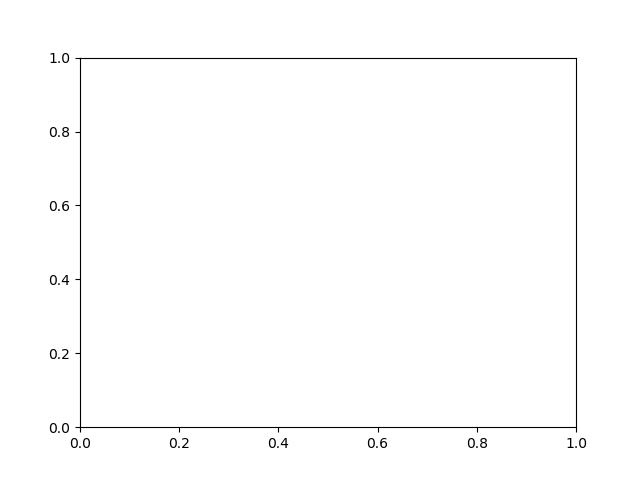

Step : 0, Signals : 0
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([0.])
#####In signal : tensor([1., 0.]), 
Step : 1, Signals : 1
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

Likelihood of sample : tensor([0.2420])
tensor([0.])
tensor([0.9776])
Step : 2, Signals : 1
Weights : tensor([-0.0109]), mean : tensor([0.]), exp_error : tensor([1.]), uncertainty : tensor([21.8543])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([0.8798])
#####In signal : tensor([0., 1.]), 
Step : 3, Signals : 2
Weights : tensor([-0.0109]), mean : tensor([0.]), exp_error : tensor([1.]), uncertainty : ten

Weights : tensor([-0.0109]), mean : tensor([0.]), exp_error : tensor([1.]), uncertainty : tensor([21.8543])
Weights : tensor([0.4884]), mean : tensor([0.9386]), exp_error : tensor([0.5111]), uncertainty : tensor([0.2555])

tensor([0.0647])
tensor([0.])
Step : 30, Signals : 2
Weights : tensor([-0.0109]), mean : tensor([0.]), exp_error : tensor([1.]), uncertainty : tensor([21.8543])
Weights : tensor([0.4884]), mean : tensor([0.9386]), exp_error : tensor([0.5111]), uncertainty : tensor([0.2555])

tensor([0.0583])
tensor([0.])
Step : 31, Signals : 2
Weights : tensor([-0.0109]), mean : tensor([0.]), exp_error : tensor([1.]), uncertainty : tensor([21.8543])
Weights : tensor([0.4884]), mean : tensor([0.9386]), exp_error : tensor([0.5111]), uncertainty : tensor([0.2555])

tensor([0.0524])
tensor([0.])
Step : 32, Signals : 2
Weights : tensor([-0.0109]), mean : tensor([0.]), exp_error : tensor([1.]), uncertainty : tensor([21.8543])
Weights : tensor([0.4884]), mean : tensor([0.9386]), exp_error :

Weights : tensor([-0.0172]), mean : tensor([0.0029]), exp_error : tensor([0.5011]), uncertainty : tensor([10.3499])
Weights : tensor([0.7281]), mean : tensor([0.9367]), exp_error : tensor([0.3392]), uncertainty : tensor([0.1696])

tensor([0.7861])
tensor([0.])
Step : 59, Signals : 4
Weights : tensor([-0.0172]), mean : tensor([0.0029]), exp_error : tensor([0.5011]), uncertainty : tensor([10.3499])
Weights : tensor([0.7281]), mean : tensor([0.9367]), exp_error : tensor([0.3392]), uncertainty : tensor([0.1696])

tensor([0.7075])
tensor([0.])
Step : 60, Signals : 4
Weights : tensor([-0.0172]), mean : tensor([0.0029]), exp_error : tensor([0.5011]), uncertainty : tensor([10.3499])
Weights : tensor([0.7281]), mean : tensor([0.9367]), exp_error : tensor([0.3392]), uncertainty : tensor([0.1696])

tensor([0.6367])
tensor([0.])
Step : 61, Signals : 4
Weights : tensor([-0.0172]), mean : tensor([0.0029]), exp_error : tensor([0.5011]), uncertainty : tensor([10.3499])
Weights : tensor([0.7281]), mean

Weights : tensor([0.8196]), mean : tensor([0.8967]), exp_error : tensor([0.1323]), uncertainty : tensor([0.0662])

tensor([0.4782])
tensor([0.])
Step : 85, Signals : 12
Weights : tensor([-0.0931]), mean : tensor([0.6463]), exp_error : tensor([0.2882]), uncertainty : tensor([0.5759])
Weights : tensor([0.8196]), mean : tensor([0.8967]), exp_error : tensor([0.1323]), uncertainty : tensor([0.0662])

tensor([0.4304])
tensor([0.])
Step : 86, Signals : 12
Weights : tensor([-0.0931]), mean : tensor([0.6463]), exp_error : tensor([0.2882]), uncertainty : tensor([0.5759])
Weights : tensor([0.8196]), mean : tensor([0.8967]), exp_error : tensor([0.1323]), uncertainty : tensor([0.0662])

tensor([0.3874])
tensor([0.])
Step : 87, Signals : 12
Weights : tensor([-0.0931]), mean : tensor([0.6463]), exp_error : tensor([0.2882]), uncertainty : tensor([0.5759])
Weights : tensor([0.8196]), mean : tensor([0.8967]), exp_error : tensor([0.1323]), uncertainty : tensor([0.0662])

tensor([0.3486])
tensor([0.])
Ste

Likelihood of sample : tensor([0.6098])
tensor([0.])
tensor([0.6770])
#####In signal : tensor([1., 0.]), 
Step : 111, Signals : 22
Weights : tensor([-0.1321]), mean : tensor([0.6322]), exp_error : tensor([0.2099]), uncertainty : tensor([0.4412])
Weights : tensor([0.7266]), mean : tensor([0.8090]), exp_error : tensor([0.1309]), uncertainty : tensor([0.1240])

Likelihood of sample : tensor([0.3361])
tensor([0.])
tensor([1.2675])
#####In signal : tensor([1., 1.]), 
Step : 112, Signals : 23
Weights : tensor([-0.1252]), mean : tensor([0.4885]), exp_error : tensor([0.2273]), uncertainty : tensor([0.7509])
Weights : tensor([0.7266]), mean : tensor([0.8090]), exp_error : tensor([0.1309]), uncertainty : tensor([0.1240])

Likelihood of sample : tensor([0.4950])
Likelihood of sample : tensor([0.4940])
tensor([0.9421])
tensor([0.6674])
#####In signal : tensor([1., 1.]), 
Step : 113, Signals : 24
Weights : tensor([-0.1098]), mean : tensor([0.3767]), exp_error : tensor([0.2288]), uncertainty : tenso

Weights : tensor([0.7053]), mean : tensor([0.7731]), exp_error : tensor([0.1193]), uncertainty : tensor([0.1385])

tensor([1.3176])
tensor([0.])
Step : 136, Signals : 33
Weights : tensor([-0.1328]), mean : tensor([0.4963]), exp_error : tensor([0.2904]), uncertainty : tensor([0.9382])
Weights : tensor([0.7053]), mean : tensor([0.7731]), exp_error : tensor([0.1193]), uncertainty : tensor([0.1385])

tensor([1.1859])
tensor([0.])
#####In signal : tensor([1., 0.]), 
Step : 137, Signals : 34
Weights : tensor([-0.1328]), mean : tensor([0.4963]), exp_error : tensor([0.2904]), uncertainty : tensor([0.9382])
Weights : tensor([0.7053]), mean : tensor([0.7731]), exp_error : tensor([0.1193]), uncertainty : tensor([0.1385])

Likelihood of sample : tensor([0.3265])
tensor([0.])
tensor([1.1600])
Step : 138, Signals : 34
Weights : tensor([-0.1458]), mean : tensor([0.7124]), exp_error : tensor([0.3134]), uncertainty : tensor([0.4837])
Weights : tensor([0.7053]), mean : tensor([0.7731]), exp_error : tens

Weights : tensor([0.7273]), mean : tensor([0.8421]), exp_error : tensor([0.1003]), uncertainty : tensor([0.0762])

tensor([0.7425])
tensor([0.])
Step : 163, Signals : 39
Weights : tensor([-0.1278]), mean : tensor([0.5613]), exp_error : tensor([0.2352]), uncertainty : tensor([0.6248])
Weights : tensor([0.7273]), mean : tensor([0.8421]), exp_error : tensor([0.1003]), uncertainty : tensor([0.0762])

tensor([0.6682])
tensor([0.])
#####In signal : tensor([1., 0.]), 
Step : 164, Signals : 40
Weights : tensor([-0.1278]), mean : tensor([0.5613]), exp_error : tensor([0.2352]), uncertainty : tensor([0.6248])
Weights : tensor([0.7273]), mean : tensor([0.8421]), exp_error : tensor([0.1003]), uncertainty : tensor([0.0762])

Likelihood of sample : tensor([0.8000])
tensor([0.])
tensor([0.9311])
Step : 165, Signals : 40
Weights : tensor([-0.1225]), mean : tensor([0.5814]), exp_error : tensor([0.1878]), uncertainty : tensor([0.4682])
Weights : tensor([0.7273]), mean : tensor([0.8421]), exp_error : tens

Weights : tensor([0.7725]), mean : tensor([0.8243]), exp_error : tensor([0.0791]), uncertainty : tensor([0.0680])

tensor([0.2949])
tensor([0.])
Step : 190, Signals : 44
Weights : tensor([-0.1093]), mean : tensor([0.4809]), exp_error : tensor([0.1686]), uncertainty : tensor([0.5692])
Weights : tensor([0.7725]), mean : tensor([0.8243]), exp_error : tensor([0.0791]), uncertainty : tensor([0.0680])

tensor([0.2654])
tensor([0.])
Step : 191, Signals : 44
Weights : tensor([-0.1093]), mean : tensor([0.4809]), exp_error : tensor([0.1686]), uncertainty : tensor([0.5692])
Weights : tensor([0.7725]), mean : tensor([0.8243]), exp_error : tensor([0.0791]), uncertainty : tensor([0.0680])

tensor([0.2388])
tensor([0.])
Step : 192, Signals : 44
Weights : tensor([-0.1093]), mean : tensor([0.4809]), exp_error : tensor([0.1686]), uncertainty : tensor([0.5692])
Weights : tensor([0.7725]), mean : tensor([0.8243]), exp_error : tensor([0.0791]), uncertainty : tensor([0.0680])

tensor([0.2150])
tensor([0.])


In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

epochs = 200

x_fire = np.array(random.sample(range(1,epochs), epochs // 8))

#x_fire = np.array(list(range(0,epochs,4)))
y_fire = (x_fire + 2)
#print(x_fire)
#x_fire = []
signals = 0
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)
    
    
    if 1 in in_stream:
        print("#####In signal : {}, ".format(in_stream.data))
        signals += 1
    
    print("Step : {}, Signals : {}".format(e, signals))
    #print()    
    #print()
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    
    s = model(in_stream)
    #draw_spikes(s,[2,1], ax)
    #fig.canvas.draw()
    #time.sleep(0.1)

In [4]:
def get_uncertainty( c):
       
        v = (torch.log10(c)/torch.log10(torch.tensor(0.9).float())) 
        return v**1/2
    
print(get_uncertainty(torch.tensor(0.1).float()))

tensor(10.9272)
